# Определение возраста покупателей для супермаркета "Хлеб-Соль"

# Исследовательский анализ данных

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Наша задача - построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

Импортируем необходимые библиотеки, убираем ограничения на количество столбцов, отключаем предупреждения.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
pd.options.display.max_columns = None
import warnings
warnings.simplefilter('ignore')
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Загружаем датасет, проверяем вывод.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Ознакомимся с информацией, посмотрим соответствуют ли типы ячеек назначению.

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [8]:
features, target = next(train_gen_flow)

Напечатаем на экране 12 фотографий и посмотрим, как устроен датасет.

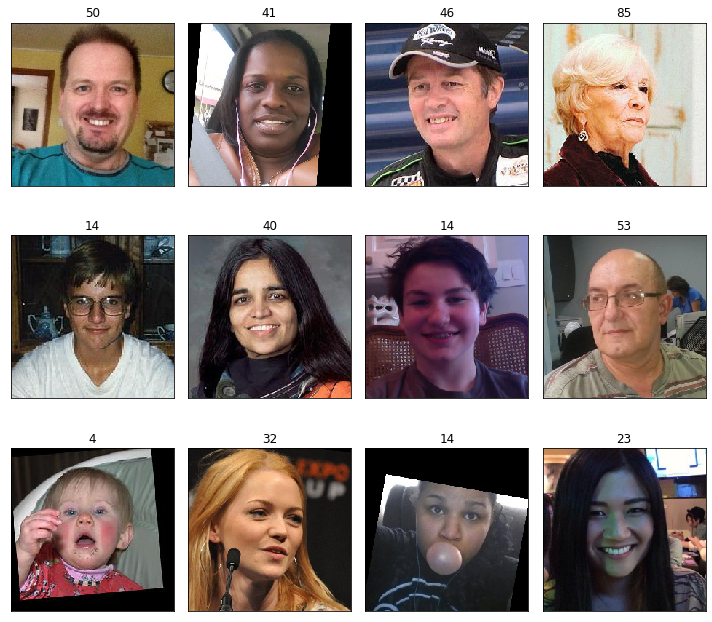

In [9]:
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Размер полученных изображений в большинстве случаев одинаков, некоторые изображения повернуты на величину до 20 градусов, изображения цветные, немного различные по гамме; различия в гамме связаны с использованием разной фотоаппаратуры, разных условий фотографирования.

Построим график распределения возраста в выборке.

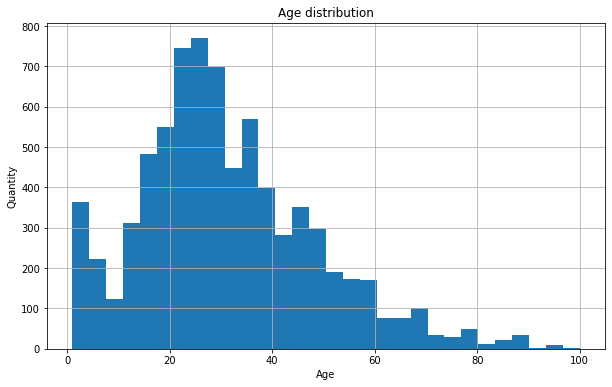

In [10]:
hist = labels['real_age'].hist(bins=30, figsize=[10,6]);
hist.set_title('Age distribution');
hist.set_xlabel('Age');
hist.set_ylabel('Quantity');

Распределение имеет пик на уровне 23-25 лет, имеется достаточно фотографий людей с возрастом от 17 до 37 лет, что немаловажно, ведь мы пытаемся контролировать кассиров на предмет продажи алкоголя несовершеннолетним. Остальных данных меньше, и если группа до 12 лет не так важна(малый ценник, отсутствие личного кабинета), то минусом данной выборки является отсутствие достаточного количесва данных по группе 60+.

# Обучение модели

Перенесем сюда код обучения модели и её результат вывода на экран.

```python

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd
import numpy as np


def load_train(path):

    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale = 1./255,
                                       horizontal_flip=True,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2
                                       )

    train_flow = train_datagen.flow_from_dataframe(dataframe = pd.read_csv(path + 'labels.csv'),
                                              directory = path + 'final_files/',
                                              x_col='file_name',
                                              y_col='real_age',
                                              target_size=(224, 224),
                                              subset='training',
                                              batch_size=16,
                                              class_mode='raw',
                                              seed=42
                                               )

    return train_flow

def load_test(path):
    test_data = ImageDataGenerator(validation_split=0.25, rescale = 1./255)
    test_flow = test_data.flow_from_dataframe(dataframe=pd.read_csv(path + 'labels.csv'),
                                            directory = path + 'final_files/',
                                            x_col='file_name',
                                            y_col='real_age',
                                            target_size=(224,224),
                                            subset='validation',
                                            batch_size=16,
                                            class_mode='raw',
                                            seed=42
                                              )

    return test_flow

def create_model(input_shape):
    optimizer = Adam(lr=0.0003)
    backbone = ResNet50(input_shape=input_shape,
                     include_top=False,
                     weights='imagenet')
    model = Sequential()

    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=30, steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/30
356/356 - 188s - loss: 193.4500 - mae: 10.4349 - val_loss: 415.6614 - val_mae: 15.3905
Epoch 2/30
356/356 - 89s - loss: 132.3589 - mae: 8.7345 - val_loss: 243.0006 - val_mae: 11.6463
Epoch 3/30
356/356 - 89s - loss: 109.3963 - mae: 7.8783 - val_loss: 116.8562 - val_mae: 8.2304
Epoch 4/30
356/356 - 89s - loss: 99.2219 - mae: 7.5113 - val_loss: 133.9744 - val_mae: 8.3775
Epoch 5/30
356/356 - 89s - loss: 85.5357 - mae: 7.0338 - val_loss: 186.6236 - val_mae: 10.5444
Epoch 6/30
356/356 - 89s - loss: 80.4759 - mae: 6.8130 - val_loss: 87.9601 - val_mae: 7.1758
Epoch 7/30
356/356 - 89s - loss: 74.4871 - mae: 6.5673 - val_loss: 104.4421 - val_mae: 7.6214
Epoch 8/30
356/356 - 89s - loss: 70.1167 - mae: 6.3315 - val_loss: 91.2854 - val_mae: 7.2792
Epoch 9/30
356/356 - 89s - loss: 68.3333 - mae: 6.2242 - val_loss: 100.1628 - val_mae: 7.5118
Epoch 10/30
356/356 - 89s - loss: 71.9528 - mae: 6.4315 - val_loss: 89.2406 - val_mae: 7.0943
Epoch 11/30
356/356 - 89s - loss: 56.3791 - mae: 5.7480 - val_loss: 82.3430 - val_mae: 6.7400
Epoch 12/30
356/356 - 89s - loss: 58.6984 - mae: 5.8109 - val_loss: 147.2640 - val_mae: 8.8732
Epoch 13/30
356/356 - 89s - loss: 53.1412 - mae: 5.5723 - val_loss: 85.6917 - val_mae: 6.6998
Epoch 14/30
356/356 - 89s - loss: 54.4004 - mae: 5.5904 - val_loss: 127.8546 - val_mae: 8.7547
Epoch 15/30
356/356 - 89s - loss: 50.3580 - mae: 5.4656 - val_loss: 85.2461 - val_mae: 6.8541
Epoch 16/30
356/356 - 89s - loss: 44.6617 - mae: 5.0936 - val_loss: 78.0865 - val_mae: 6.3700
Epoch 17/30
356/356 - 90s - loss: 37.8134 - mae: 4.7457 - val_loss: 78.0158 - val_mae: 6.5139
Epoch 18/30
356/356 - 89s - loss: 46.0189 - mae: 5.1426 - val_loss: 91.9182 - val_mae: 7.4966
Epoch 19/30
356/356 - 88s - loss: 41.8463 - mae: 4.9094 - val_loss: 83.9378 - val_mae: 6.7842
Epoch 20/30
356/356 - 88s - loss: 39.1711 - mae: 4.7931 - val_loss: 144.3567 - val_mae: 8.9306
Epoch 21/30
356/356 - 88s - loss: 33.7809 - mae: 4.4875 - val_loss: 74.4443 - val_mae: 6.4504
Epoch 22/30
356/356 - 88s - loss: 35.1881 - mae: 4.5474 - val_loss: 67.5199 - val_mae: 6.0541
Epoch 23/30
356/356 - 88s - loss: 30.8995 - mae: 4.2643 - val_loss: 86.2819 - val_mae: 6.7496
Epoch 24/30
356/356 - 88s - loss: 31.5143 - mae: 4.2966 - val_loss: 78.0647 - val_mae: 6.3238
Epoch 25/30
356/356 - 88s - loss: 29.1333 - mae: 4.1332 - val_loss: 69.5654 - val_mae: 6.1148
Epoch 26/30
356/356 - 88s - loss: 27.1343 - mae: 4.0234 - val_loss: 67.5352 - val_mae: 6.0510
Epoch 27/30
356/356 - 88s - loss: 34.1152 - mae: 4.4346 - val_loss: 126.2902 - val_mae: 8.1341
Epoch 28/30
356/356 - 88s - loss: 37.5782 - mae: 4.6777 - val_loss: 109.2188 - val_mae: 8.0706
Epoch 29/30
356/356 - 88s - loss: 28.1377 - mae: 4.0717 - val_loss: 75.0305 - val_mae: 6.2908
Epoch 30/30
356/356 - 88s - loss: 25.8798 - mae: 3.9190 - val_loss: 79.4865 - val_mae: 6.4902
119/119 - 9s - loss: 79.4865 - mae: 6.4902
Test MAE: 6.4902
```

# Анализ обученной модели

Таким образом, была проведена работа по построению модели, которая по фотографии определяет приблизительный возраст человека. Имея в распоряжении набор фотографий людей с указанием возраста, мы провели осследовательский анализ, а также построили нейронную сеть на базе ResNet50, которая определяем возраст человека на фотографии, ошибаясь в среднем меньше, чем на 6,5 лет.

В целом позволяет решать поставленные бизнесом задачи по рекомендации товаров определенным возрастным группам покупателей, а также поверхностно контролировать добросовестность кассоров при продаже алкоголя.